In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import ipywidgets as widgets
from ipywidgets import interact







<div style="height:390px"></div>

# 2
#### 2.1
Nyquist säger att vi minst måste ha $f_s = 16$ kHz om vi bortser från störning. Störning finns från $11$ kHz och uppåt. Vid $f_s = 16$ kHz skulle t.ex. $11$ kHz vikas till $f_{\text{alias}}=5$ kHz, alltså **in i vårt nyttoband $0<f<8kHz$**.

Men vi har analogt filter före samplingen => så dämpning sker innan vikning alltså kan $f_s=16$ kHz väljas.

(Hårdvaran begränsar samplingsfrekvensen till max $24$kHz)


gammal motivering för annan uppsättning:
( Zon 1: $8-12$ kHz Spelar ingen roll, viks inte fel
  Zon 2: $12-16$ kHz viks inte heller in i 0-8 kHz zonen utan räcker att dämpa
  Zon 3: Måste dämpas med ≥ 72 dB för att inte märkas när det viks in i 0-8 kHz bandet.)

#### 2.2
Vi väljer:


In [46]:
# Spec för A-A filter:

# Gammal spec: bättre filter men måste ha digital efterprocessning:
#fs = 24e3 # Samplingsfrekvens , gammla värdet
#fb = 16e3 # gammla värdet

fs = 16e3 # Samplingsfrekvens
fp = 8e3  # Passbandfrekvens
fb = 11e3 # Stoppbandfrekvens (start för kritiskt stopband – här krävs ~72 dB)
mr = 3 # Max rippel (enligt uppgiftsbeskrivning)
md = np.abs(20*np.log10(2**-12)) # Min dämpning (=72.2dB – motsvarar ett halvt LSB för 12 bitar.)    

# Konvertera till rad/s
wp = fp * 2 * np.pi
wb = fb * 2 * np.pi

print(f'fs: {fs}, fp: {fp}, fb: {fb}, mr: {mr}, md: {md}, wp: {wp}, wb: {wb}')

fs: 16000.0, fp: 8000.0, fb: 11000.0, mr: 3, md: 72.24719895935549, wp: 50265.48245743669, wb: 69115.03837897544


#### 2.3
Chebyshev I: tillåter ripple i passbandet och ger lägre ordning än Butterworth för samma stopbandsdämpning

In [47]:
# Butterworth 
N_butt, Wn_butt = signal.buttord(wp, wb, mr, md, analog=True)

# Chebyshev I
N_cheb1, Wn_cheb1 = signal.cheb1ord(wp, wb, mr, md, analog=True)

print(f"Butterworth:  N = {N_butt},  cutoff ~ {Wn_butt/(2*np.pi):.1f} Hz")
print(f"Chebyshev I:  N = {N_cheb1}, cutoff ~ {Wn_cheb1/(2*np.pi):.1f} Hz")
print("Välj Chebyshev I – lägre ordning, enklare och uppfyller exakt den tillåtna 3 dB-rippeln.")

Butterworth:  N = 27,  cutoff ~ 8000.7 Hz
Chebyshev I:  N = 11, cutoff ~ 8000.0 Hz
Välj Chebyshev I – lägre ordning, enklare och uppfyller exakt den tillåtna 3 dB-rippeln.


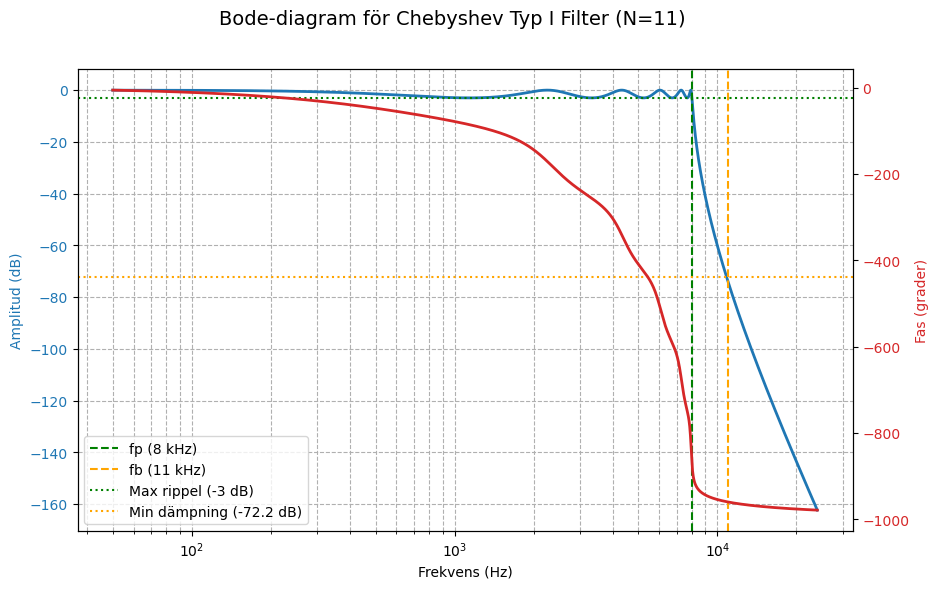

In [48]:
N, Wn = signal.cheb1ord(wp=wp, ws=wb, gpass=mr, gstop=md, analog=True)
b, a = signal.cheby1(N, mr, Wn, 'low', analog=True)
LP_filter = signal.lti(b,a)

w_range = 2*np.pi*np.logspace(np.log10(50), np.log10(24e3), 2000)
w, mag, phase = signal.bode(LP_filter, w=w_range)

# Skapa figuren
fig, ax1 = plt.subplots(figsize=(10, 6))
fig.suptitle(f'Bode-diagram för Chebyshev Typ I Filter (N={int(N)})', fontsize=14)

# Amplitudplot
# Konvertera W (rad/s) till frekvens i Hz
freq_hz = w / (2 * np.pi) 
ax1.semilogx(freq_hz, mag, color='tab:blue', linewidth=2)
ax1.set_xlabel('Frekvens (Hz)')
ax1.set_ylabel('Amplitud (dB)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which="both", linestyle='--')

# Fasplot
ax2 = ax1.twinx()  # Skapar en delad x-axel men egen y-axel
ax2.semilogx(freq_hz, phase, color='tab:red', linewidth=2, linestyle='-')
ax2.set_ylabel('Fas (grader)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Lägg till specifikationslinjer
ax1.axvline(fp, color='green', linestyle='--', label=f'fp ({fp/1e3:.0f} kHz)')
ax1.axvline(fb, color='orange', linestyle='--', label=f'fb ({fb/1e3:.0f} kHz)')
ax1.axhline(-mr, color='green', linestyle=':' , label=f'Max rippel ({-mr} dB)')
ax1.axhline(-md, color='orange', linestyle=':', label=f'Min dämpning ({-md:.1f} dB)')
ax1.legend(loc='lower left')

plt.show()

#### 2.4
#### 2.5

In [49]:
def sim_plot(f_sig_khz=3.0, f_int_khz=15.0, window_ms=2.0):
    # 4
    # För att kunna simulera som fejk "kontinuerlig" tid så använder vi oversampling med M.
    Ts = 1/fs        # Samplings perioden
    M  = 200       
    dt = Ts/M        # time step so samples align
    T  = 0.02        # simulate 20 ms
    t  = np.arange(0, T, dt)

    f_sig = f_sig_khz*1e3 # signalens frekvens i Hz
    f_int = f_int_khz*1e3 # störningens frekvens i Hz

    x_sig = np.sin(2*np.pi*f_sig*t) # grundsignal
    x_int = np.sin(2*np.pi*f_int*t) # störningssignal
    u     = x_sig + x_int           # insignal    

    # Analog simulering genom AA-filtret
    tout, y, _ = signal.lsim(LP_filter, U=u, T=t)

    # sampla utsignalen vid fs
    idx = np.arange(0, len(tout), M)  # ta var M:te punkt
    t_s = tout[idx]
    y_s = y[idx]

    # enkel zoom: [0, window]
    w = max(0.0001, min(window_ms/1000.0, T))

    # Plotta
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax00, ax01, ax10, ax11 = axes.ravel()

    def stylize(ax, title, xlab='Tid (s)', ylab='Amplitud'):
        ax.set_title(title); ax.set(xlabel=xlab, ylabel=ylab)
        ax.grid(True); ax.set_xlim(0, w)

    ax00.plot(t, x_sig);              stylize(ax00, 'Grundsignal (tidsdomän)')
    ax01.plot(t, x_int);              stylize(ax01, 'Störningssignal (tidsdomän)')
    ax10.plot(t, u);                  stylize(ax10, 'Insignal (tidsdomän)')

    ax11.plot(tout, y, label='Analogt efter AA-filter')
    ax11.stem(t_s, y_s, linefmt='C1-', markerfmt='C1o', basefmt=' ', label=f'Samplad vid {fs/1e3:.0f} kHz')
    stylize(ax11, 'Filtrerad signal + sampling')
    ax11.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    # 5. FFT av samplad signal
    N   = len(y_s)
    win = np.hanning(N)                  # valfritt fönster
    X   = np.fft.rfft(y_s * win)
    f   = np.fft.rfftfreq(N, d=1/fs)     # Hz

    # Normalisering: enkel-sidigt spektrum, 1 V sinus -> topp ≈ 1
    A = (2.0/np.sum(win)) * np.abs(X)    # ingen extra *N
    A[0] /= 2.0
    if N % 2 == 0:
        A[-1] /= 2.0

    # plot (en stapel per bin)
    plt.figure(figsize=(10, 4))
    markerline, stemlines, baseline = plt.stem(f/1e3, A)
    plt.setp(markerline, marker='o', markersize=3)
    plt.setp(stemlines, linewidth=1)
    plt.setp(baseline, linewidth=0)  # göm baslinjen om du vill

    # Referenslinjer
    plt.axvline(fp/1e3,  ls='--', c='green',      label=f'fp = {fp/1e3:.0f} kHz')
    plt.axvline(fb/1e3,  ls='--', c='orange', label=f'fb = {fb/1e3:.0f} kHz')

    plt.ylim(0, max(1.1*np.max(A), 1.2))
    plt.xlabel('Frekvens (kHz)')
    plt.ylabel('Amplitud (linjär)')
    plt.title('Uppgift 5: Amplitudspektrum (1 V sinus → topp = 1)')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

interact(
    sim_plot,
    f_sig_khz=widgets.FloatSlider(value=3.0, min=0.1, max=8.0, step=0.1, description='Signal (kHz)'),
    f_int_khz=widgets.FloatSlider(value=15.0, min=11.0, max=24.0, step=0.5, description='Störning (kHz)'),
    window_ms=widgets.FloatSlider(value=2.0, min=0.1, max=20.0, step=0.1, description='Fönster (ms)'),
)


interactive(children=(FloatSlider(value=3.0, description='Signal (kHz)', max=8.0, min=0.1), FloatSlider(value=…

<function __main__.sim_plot(f_sig_khz=3.0, f_int_khz=15.0, window_ms=2.0)>